# Statistical inference over human and model behavioral performance

**The purpose of this notebook is to:** 
* Visualize human and model prediction accuracy (proportion correct)
* Visualize average-human and model agreement (RMSE)
* Visualize human-human and model-human agreement (Cohen's kappa)
* Compare performance between models

**This notebook depends on:**
* Running `./generate_dataframes.py` (INTERNAL USE ONLY)
* Running `./upload_results.py` (INTERNAL USE ONLY)
* Running `./download_results.py` (PUBLIC USE)
* Running `./summarize_human_model_behavior.ipynb` (PUBLIC USE)

### Load packages

In [1]:
suppressMessages(suppressWarnings(suppressPackageStartupMessages({library(tidyverse)
library(ggthemes)
library(lme4)
library(lmerTest)
library(brms)
library(broom.mixed)
library(tidyboot)                
require('MuMIn')
})))

In [122]:
A = read_csv('../results/csv/summary/model_human_accuracies.csv')
# A = read_csv('../results/csv/models/allModels_results.csv')
AH = read_csv('../results/csv/summary/human_accuracy_by_scenario.csv')
K = read_csv('../results/csv/summary/model_human_CohensK.csv')

## preprocessing
A <- A %>%
    dplyr::rename('model_kind'='Model Kind', 
                  'encoder_training_dataset_type'='Encoder Training Dataset Type',
                  'dynamics_training_dataset_type'='Dynamics Training Dataset Type',
                  'readout_training_data_type'='Readout Train Data Type', 
                  'readout_type'='Readout Type',
                  'visual_encoder_architecture' = 'Visual encoder architecture',
                  'dynamics_model_architecture' = 'Dynamics model architecture') %>%
    mutate(dynamics_model_architecture = factor(dynamics_model_architecture)) %>%
#     left_join(AH, by='scenario') %>% 
    group_by(model_kind) %>%
    mutate(avg_model_correct = mean(model_correct)) %>%
    ungroup()


── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_character(),
  ratio = col_double(),
  diff = col_double(),
  human_correct = col_double(),
  model_correct = col_double(),
  `Encoder Pre-training Seed` = col_logical(),
  `Encoder Training Seed` = col_double(),
  `Dynamics Training Seed` = col_double(),
  ObjectCentric = col_logical(),
  Supervised = col_logical(),
  SelfSupervisedLossSelfSupervisedLoss = col_logical()
)
ℹ Use `spec()` for the full column specifications.



── Column specification ────────────────────────────────────────────────────────
cols(
  agent = col_character(),
  scenario = col_character(),
  obs_mean = col_double(),
  boot_mean = col_double(),
  ci_lb = col_double(),
  ci_ub = col_double(),
  pct_2.5 = col_double(),
  pct_97.5 = col_double()
)



── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_character(),
  Cohens_k_lb = col_double(),
  Cohens_k_med

## Visualize human and model prediction accuracy (proportion correct)


── Column specification ────────────────────────────────────────────────────────
cols(
  agent = col_character(),
  scenario = col_character(),
  obs_mean = col_double(),
  boot_mean = col_double(),
  ci_lb = col_double(),
  ci_ub = col_double(),
  pct_2.5 = col_double(),
  pct_97.5 = col_double()
)




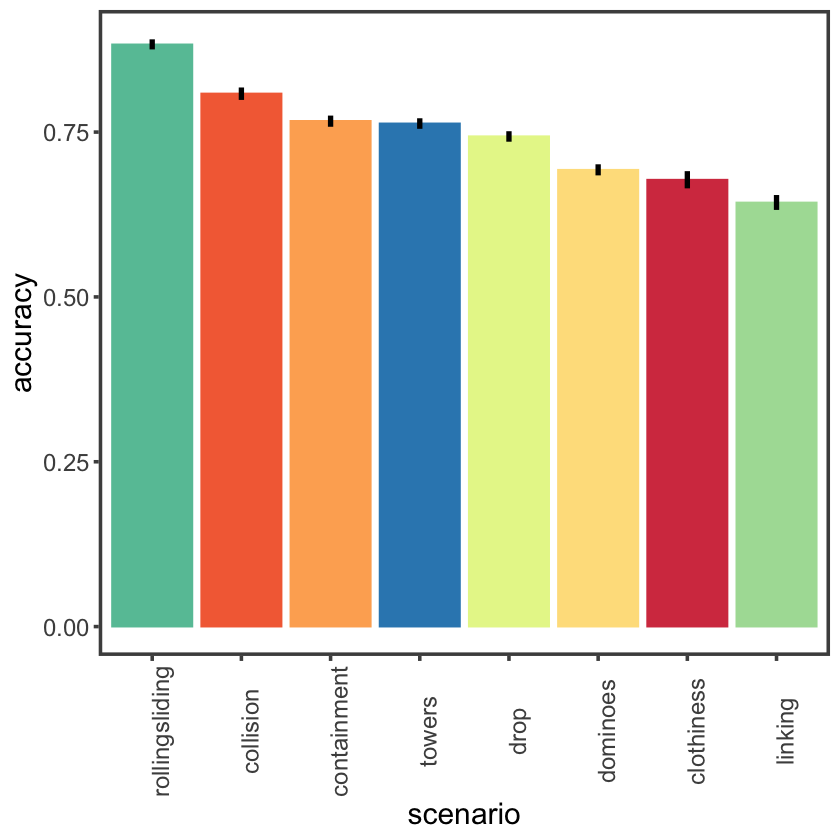

In [123]:
## human accuracy only
d = read_csv('../results/csv/summary/human_accuracy_by_scenario.csv')

## accuracy bar plot with 95% CIs
d %>%
  ggplot(aes(x=reorder(scenario,-obs_mean), y=obs_mean, color=scenario, fill=scenario)) +
  geom_bar(stat='identity') +
  geom_errorbar(aes(ymin=ci_lb, ymax = ci_ub), width = 0, size = 1.5, color='black') + 
    theme_few() +
    xlab('scenario') +
    ylab('accuracy') +
    theme(text = element_text(size=18), 
          element_line(size=1), 
          element_rect(size=2, color="#00000"),
          axis.text.x = element_text(angle=90)) +
    theme(legend.position = "none") +
    scale_fill_brewer(palette="Spectral") + scale_color_brewer(palette="Spectral")

ggsave('../results/plots/human_accuracy_across_scenarios.pdf', width=12, height = 18, units='cm')

Warning message in RColorBrewer::brewer.pal(n, pal):
“n too large, allowed maximum for palette Spectral is 11
Returning the palette you asked for with that many colors
”
Warning message in RColorBrewer::brewer.pal(n, pal):
“n too large, allowed maximum for palette Spectral is 11
Returning the palette you asked for with that many colors
”
Warning message:
“The shape palette can deal with a maximum of 6 discrete values because
more than 6 becomes difficult to discriminate; you have 8. Consider
specifying shapes manually if you must have them.”
Warning message:
“Removed 194 rows containing missing values (geom_point).”
Warning message in RColorBrewer::brewer.pal(n, pal):
“n too large, allowed maximum for palette Spectral is 11
Returning the palette you asked for with that many colors
”
Warning message in RColorBrewer::brewer.pal(n, pal):
“n too large, allowed maximum for palette Spectral is 11
Returning the palette you asked for with that many colors
”
Warning message:
“The shape palette 

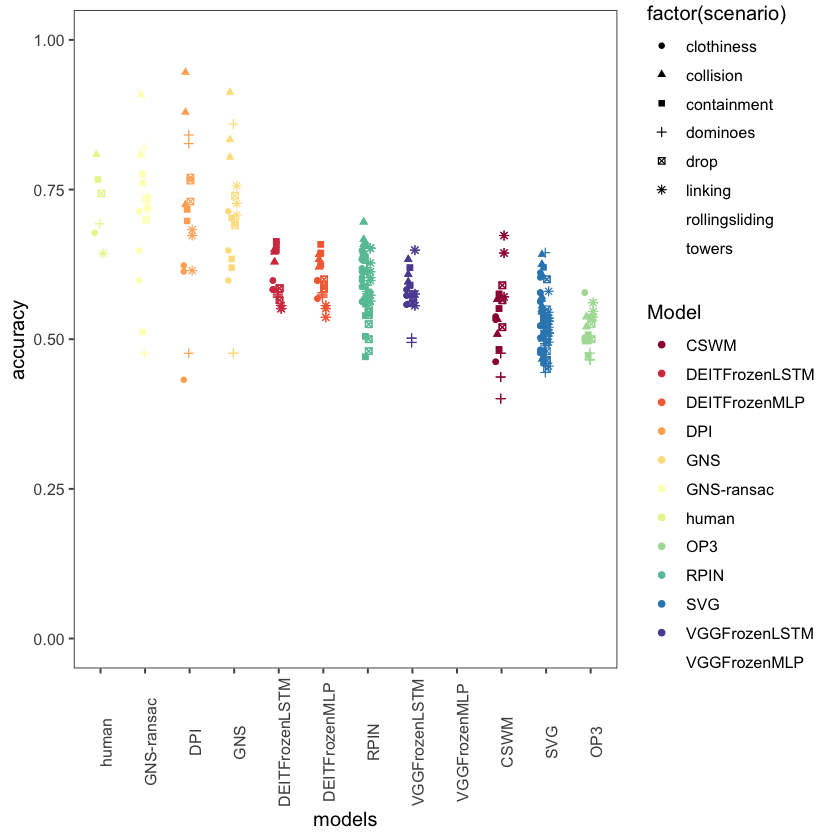

In [132]:
## human model accuracy comparison (MAIN FIGURE)
A %>%
    filter(readout_type %in% c('B')) %>%
    select(Model, model_correct, dynamics_training_dataset_type, readout_type, scenario) %>%
    bind_rows(AH %>%  dplyr::rename(Model=agent, model_correct = obs_mean) %>% select(Model, model_correct, scenario)) %>%
    ggplot(aes(x=reorder(Model,-model_correct), y=model_correct,
               color=Model, fill=Model, shape = factor(scenario))) +
    geom_point(stat='identity', position=position_dodge(0.3)) +  
#     geom_hline(aes(yintercept = human_correct)) +
#     geom_rect(aes(ymin = ci_lb, ymax = ci_ub, xmin = -Inf, xmax = Inf), color=NA, fill = 'gray', alpha = 0.05) +
#     facet_grid(rows=vars(scenario), cols=vars(dynamics_training_dataset_type)) +
    theme_few() +
    theme(axis.text.x = element_text(angle=90)) +
    xlab('models') +
    ylab('accuracy') +
    ylim(0,1) +
    scale_fill_brewer(palette="Spectral") + scale_color_brewer(palette="Spectral")

ggsave('../results/plots/human_model_accuracy_across_scenarios.pdf', width=36, height = 36, units='cm')

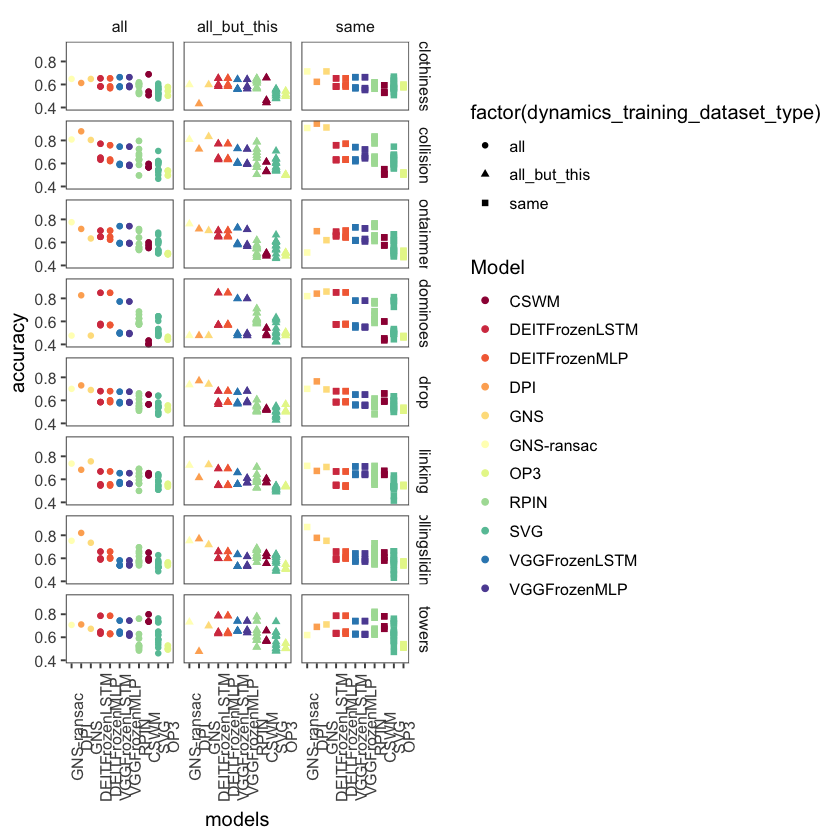

In [126]:
## human model accuracy comparison by dynamics training data
A %>%
    filter(readout_type %in% c('A','B','C')) %>%
    ggplot(aes(x=reorder(Model,-model_correct), y=model_correct,
               color=Model, fill=Model, shape = factor(dynamics_training_dataset_type))) +
    geom_point(stat='identity', position=position_dodge(0.3)) +  
    #geom_hline(aes(yintercept = human_correct)) +
#     geom_rect(aes(ymin = ci_lb, ymax = ci_ub, xmin = -Inf, xmax = Inf), color=NA, fill = 'gray', alpha = 0.05) +
    facet_grid(rows=vars(scenario), cols=vars(dynamics_training_dataset_type)) +
    theme_few() +
    theme(axis.text.x = element_text(angle=90)) +
    xlab('models') +
    ylab('accuracy') +
    scale_fill_brewer(palette="Spectral") + scale_color_brewer(palette="Spectral")

ggsave('../results/plots/human_model_accuracy_across_scenarios_by_dynamicsTraining.pdf', width=36, height = 36, units='cm')

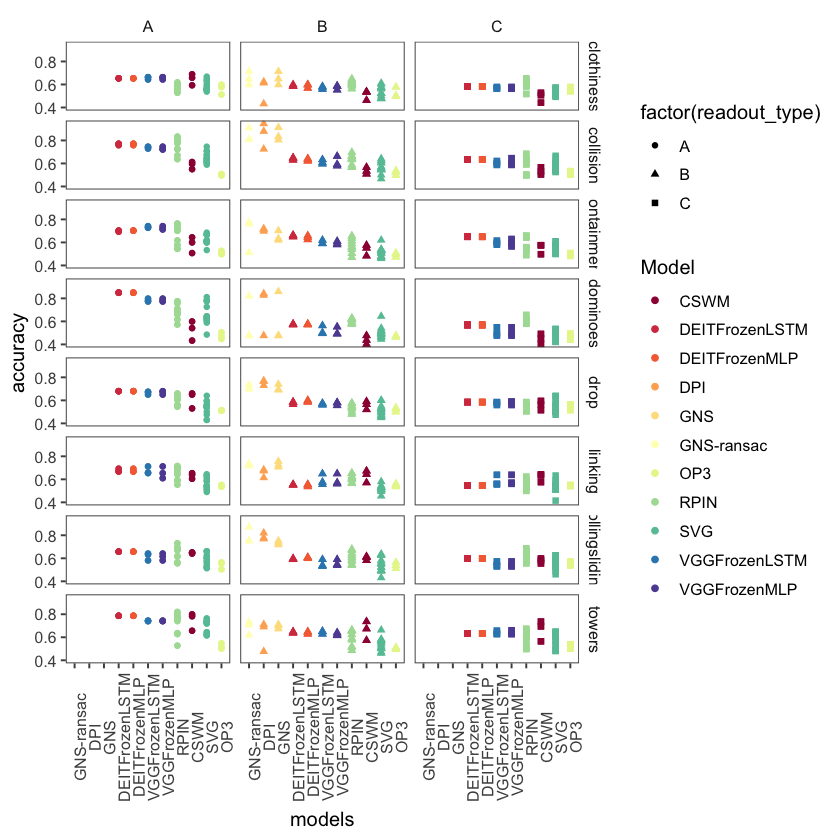

In [127]:
## A = "full sequence"
## B = "initial + predicted"
## C = "initial only"
## human model accuracy comparison by readout type

A %>%
    filter(readout_type %in% c('A','B','C')) %>%
    ggplot(aes(x=reorder(Model,-model_correct), y=model_correct,
               color=Model, fill=Model, shape = factor(readout_type))) +
    geom_point(stat='identity', position=position_dodge(0.3)) +  
    #geom_hline(aes(yintercept = human_correct)) +
#     geom_rect(aes(ymin = ci_lb, ymax = ci_ub, xmin = -Inf, xmax = Inf), color=NA, fill = 'gray', alpha = 0.05) +
    facet_grid(rows=vars(scenario), cols=vars(readout_type)) +
    theme_few() +
    theme(axis.text.x = element_text(angle=90)) +
    xlab('models') +
    ylab('accuracy') +
    scale_fill_brewer(palette="Spectral") + scale_color_brewer(palette="Spectral")

ggsave('../results/plots/human_model_accuracy_across_scenarios_by_readoutType.pdf', width=36, height = 36, units='cm')

## Visualize average-human and model agreement (RMSE)

In [75]:
## TODO

## Visualize human-human and model-human agreement (Cohen's kappa)

In [ ]:
## TODO

## Comparing performance between models

* Question 1: Visual encoder architecture (ConvNet [SVG/VGGFrozenLSTM] vs. transformer [DEITFrozenLSTM] … DEITFrozenMLP vs. SVG/VGGFrozenMLP)
* Question 2: Dynamics model RNN vs. MLP (LSTM vs. MLP for above)
* Question 3: Among unsupervised models, object-centric vs. non-object-centric
        * {CSWM, OP3} vs. {SVG}
* Question 4: Latent vs. pixel reconstruction loss
        * CSWM vs. OP3
* Question 5: RPIN vs. CSWM/OP3 (“supervised explicit object-centric” vs. “unsupervised implicit object-centric”)
* Question 6: DPI vs GNS and GNS-RANSAC (DPI is object-centric, whereas GNS is not? and GNS-RANSAC is somewhere in between.)
* Question 7: GNS vs. GNS-RANSAC
* Question 8: Particle models (GNS, GNS-RANSAC, DPI) vs. humans
    - Estimate difference between particle model accuracy and human accuracy
        ```
        model_correct ~ particleOrHuman + (1 | scenario) + (1 | training_data) + (1 | readout_type)
        ```
    - Estimate similarity between model responses and human responses
    
* Question 9: Particle models  (GNS, GNS-RANSAC, DPI) vs. remaining vision models
* Question 10: Among TDW-trained vision models, are supervised (RPIN) better than unsupervised (SVG, CSWM, OP3)
* Question 11: Posgit chsibly useful to look at how well visual encoders do alone (e.g. Readout type A vs. humans)
* Question 12: For pretrained encoder vision models (frozen), is readout B any better than readout C? If not, then none of the vision models are actually getting anything out of learning dynamics
* Question 13: For end2end vision models (CSWM, OP3, SVG, RPIN), is readout B any better than readout C? If not, then none of the vision models are actually getting anything out of learning dynamics

Dimensions: 
* “Visual encoder architecture” : [“ConvNet” “Transformer” “Neither”]
* “Dynamics model architecture” : [“LSTM”, “MLP”, “Neither”]
* “ObjectCentric”: [TRUE, FALSE, NA]
* “Supervised”: [TRUE, FALSE]
* “SelfSupervisedLoss”: [“latent”, “pixel”, “NA”]


## Q1: Visual encoder architecture (ConvNet vs. transformer)

In [76]:
## Comparison 1: Visual encoder architecture (ConvNet [SVG/VGGFrozenLSTM] vs. transformer [DEITFrozenLSTM] … DEITFrozenMLP vs. SVG/VGGFrozenMLP)
Q1 <- A %>% 
        filter(visual_encoder_architecture %in% c('ConvNet','Transformer')) %>%
        filter(readout_type %in% c('A','B','C')) 

In [77]:
M0 <- lmer(model_correct ~ (1 | scenario) + (1 | readout_type) + (1 | dynamics_training_dataset_type), data=Q1)
M1 <- lmer(model_correct ~ visual_encoder_architecture + (1 | scenario)  + (1 | readout_type) + (1 | dynamics_training_dataset_type), data=Q1)
summary(M1)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: model_correct ~ visual_encoder_architecture + (1 | scenario) +  
    (1 | readout_type) + (1 | dynamics_training_dataset_type)
   Data: Q1

REML criterion at convergence: -3011.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.6102 -0.5376 -0.0472  0.4899  3.6485 

Random effects:
 Groups                         Name        Variance  Std.Dev.
 scenario                       (Intercept) 0.0007844 0.02801 
 readout_type                   (Intercept) 0.0034942 0.05911 
 dynamics_training_dataset_type (Intercept) 0.0001148 0.01071 
 Residual                                   0.0021931 0.04683 
Number of obs: 936, groups:  
scenario, 8; readout_type, 3; dynamics_training_dataset_type, 3

Fixed effects:
                                        Estimate Std. Error        df t value
(Intercept)                            5.639e-01  3.615e-02 2.501e+00    15.6
visual_encoder_architectur

Transformer architectures outperform convnet architectures.

In [78]:
## model comparison relative to null model
anova(M0,M1)

refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
M0,5,-2649.231,-2625.023,1329.616,-2659.231,NA,NA,NA
M1,6,-3013.785,-2984.736,1512.893,-3025.785,366.554,1,1.053192e-81


Model containing `visual_encoder_architecture` as a predictor outperforms null model without it .

In [79]:
## explained variance
r.squaredGLMM(M1)

R2m,R2c
0.1379658,0.7129717


Showing that your marginal R squared is 0.14 and your conditional R squared is 0.72. 

### Transformer architecture outperforms ConvNet architecture: $b=6.670e-02,t(925)=21.2, p<0.001$

## Q2: Dynamics model RNN vs. MLP (LSTM vs. MLP for above)

In [80]:
## Comparison 2
Q2 <- A %>% 
        filter(dynamics_model_architecture %in% c('LSTM','MLP')) %>%
        mutate(dynamics_model_architecture = factor(dynamics_model_architecture)) %>%
        filter(readout_type %in% c('A','B','C'))   

In [81]:
Q2 %>% 
    group_by(dynamics_model_architecture, Model) %>%
    summarise(mean(model_correct))

`summarise()` has grouped output by 'dynamics_model_architecture'. You can override using the `.groups` argument.



dynamics_model_architecture,Model,mean(model_correct)
<fct>,<chr>,<dbl>
LSTM,DEITFrozenLSTM,0.6414327
LSTM,VGGFrozenLSTM,0.6206286
MLP,DEITFrozenMLP,0.6411965
MLP,VGGFrozenMLP,0.6191530


In [82]:
M0 <- lmer(model_correct ~ (1 | scenario) + (1 | readout_type) + (1 | dynamics_training_dataset_type), data=Q2)
M2 <- lmer(model_correct ~ dynamics_model_architecture + (1 | scenario) + (1 | readout_type) + (1 | dynamics_training_dataset_type), data=Q2)
summary(M2)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: model_correct ~ dynamics_model_architecture + (1 | scenario) +  
    (1 | readout_type) + (1 | dynamics_training_dataset_type)
   Data: Q2

REML criterion at convergence: -2062.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.9567 -0.5643 -0.0961  0.4892  3.6287 

Random effects:
 Groups                         Name        Variance  Std.Dev.
 scenario                       (Intercept) 1.007e-03 0.031737
 readout_type                   (Intercept) 4.769e-03 0.069055
 dynamics_training_dataset_type (Intercept) 2.966e-05 0.005446
 Residual                                   1.464e-03 0.038266
Number of obs: 576, groups:  
scenario, 8; readout_type, 3; dynamics_training_dataset_type, 3

Fixed effects:
                                 Estimate Std. Error         df t value
(Intercept)                     6.310e-01  4.160e-02  2.358e+00  15.170
dynamics_model_architectureMLP -8.559e

### Recurrence (LSTM) does not outperform MLP: $b=-8.559e-04 ,t(563)=-0.268, p=0.788$

In [83]:
anova(M0,M2)

refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
M0,5,-2066.661,-2044.880,1038.330,-2076.661,NA,NA,NA
M2,6,-2064.733,-2038.596,1038.366,-2076.733,0.07216062,1,0.7882165


In [84]:
## explained variance
r.squaredGLMM(M2)

R2m,R2c
2.5234e-05,0.7985842


## Q3:  Among unsupervised models, object-centric vs. non-object-centric
{CSWM, OP3} vs. {SVG}

In [85]:
## Comparison 3
Q3 <- A %>% 
        filter(Supervised==FALSE) %>%
        filter(ObjectCentric %in% c(TRUE,FALSE)) %>%
        filter(readout_type %in% c('A','B','C'))   

In [86]:
M0 <- lmer(model_correct ~ (1 | scenario) + (1 | readout_type) + (1 | dynamics_training_dataset_type), data=Q3)
M3 <- lmer(model_correct ~ ObjectCentric + (1 | scenario) + (1 | readout_type) + (1 | dynamics_training_dataset_type), data=Q3)
summary(M3)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: model_correct ~ ObjectCentric + (1 | scenario) + (1 | readout_type) +  
    (1 | dynamics_training_dataset_type)
   Data: Q3

REML criterion at convergence: -1799.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.6633 -0.6550 -0.0472  0.5750  4.0407 

Random effects:
 Groups                         Name        Variance  Std.Dev.
 scenario                       (Intercept) 0.0006250 0.02500 
 readout_type                   (Intercept) 0.0010708 0.03272 
 dynamics_training_dataset_type (Intercept) 0.0003029 0.01740 
 Residual                                   0.0033666 0.05802 
Number of obs: 648, groups:  
scenario, 8; readout_type, 3; dynamics_training_dataset_type, 3

Fixed effects:
                    Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)         0.563902   0.023353   4.119809  24.146 1.36e-05 ***
ObjectCentricTRUE  -0.014468   0.004587 635.000070  

### ObjectCentric representations better than non-object centric: $b=-0.0145 ,t(635)=-3.154, p=0.0017$

In [87]:
anova(M0,M3)

refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
M0,5,-1794.297,-1771.927,902.1484,-1804.297,NA,NA,NA
M3,6,-1802.183,-1775.339,907.0913,-1814.183,9.885821,1,0.001665572


In [88]:
## explained variance
r.squaredGLMM(M3)

R2m,R2c
0.009555375,0.3785207


## Q4: Latent vs. pixel reconstruction loss
CSWM vs. OP3

In [89]:
## Comparison 4
Q4 <- A %>% 
        filter(Supervised==FALSE) %>%
        filter(ObjectCentric %in% c(TRUE,FALSE)) %>%
        filter(Model %in% c('CSWM','OP3')) %>%
        filter(readout_type %in% c('A','B','C'))   

In [90]:
M0 <- lmer(model_correct ~ (1 | scenario) + (1 | readout_type) + (1 | dynamics_training_dataset_type), data=Q4)
M4 <- lmer(model_correct ~ Model + (1 | scenario) + (1 | readout_type) + (1 | dynamics_training_dataset_type), data=Q4)
summary(M4)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: model_correct ~ Model + (1 | scenario) + (1 | readout_type) +  
    (1 | dynamics_training_dataset_type)
   Data: Q4

REML criterion at convergence: -912.9

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.43784 -0.64125 -0.00185  0.56560  3.09585 

Random effects:
 Groups                         Name        Variance  Std.Dev.
 scenario                       (Intercept) 0.0016606 0.04075 
 readout_type                   (Intercept) 0.0003537 0.01881 
 dynamics_training_dataset_type (Intercept) 0.0002279 0.01509 
 Residual                                   0.0020602 0.04539 
Number of obs: 288, groups:  
scenario, 8; readout_type, 3; dynamics_training_dataset_type, 3

Fixed effects:
              Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)   0.578973   0.020390   9.677415   28.39 1.21e-10 ***
ModelOP3     -0.059077   0.005349 275.000020  -11.04  < 2e-16 *

### Latent (CSWM) better than pixel reconstruction (OP3) loss:  $b= -0.059 ,t(275)=-11.04, p<2e-16$

In [91]:
anova(M0,M4)

refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
M0,5,-816.2281,-797.9133,413.1140,-826.2281,NA,NA,NA
M4,6,-915.5321,-893.5544,463.7661,-927.5321,101.3041,1,7.889263e-24


In [92]:
## explained variance
r.squaredGLMM(M4)

R2m,R2c
0.1690977,0.6021285


## Q5: RPIN vs. CSWM/OP3 (“supervised explicit object-centric” vs. “unsupervised implicit object-centric”)

In [93]:
## Comparison 3
Q5 <- A %>% 
        filter(Supervised %in% c(TRUE,FALSE)) %>%
        filter(Model %in% c('CSWM','OP3', 'RPIN')) %>%
        filter(readout_type %in% c('A','B','C'))   

In [94]:
M0 <- lmer(model_correct ~ (1 | scenario) + (1 | readout_type) + (1 | dynamics_training_dataset_type), data=Q5)
M5 <- lmer(model_correct ~ Supervised + (1 | scenario) + (1 | readout_type) + (1 | dynamics_training_dataset_type), data=Q5)
summary(M5)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: model_correct ~ Supervised + (1 | scenario) + (1 | readout_type) +  
    (1 | dynamics_training_dataset_type)
   Data: Q5

REML criterion at convergence: -1941.3

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.39793 -0.70896 -0.02854  0.61610  3.14622 

Random effects:
 Groups                         Name        Variance  Std.Dev.
 scenario                       (Intercept) 0.0005010 0.02238 
 readout_type                   (Intercept) 0.0009805 0.03131 
 dynamics_training_dataset_type (Intercept) 0.0003256 0.01804 
 Residual                                   0.0036852 0.06071 
Number of obs: 720, groups:  
scenario, 8; readout_type, 3; dynamics_training_dataset_type, 3

Fixed effects:
                Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)    5.494e-01  2.260e-02 4.194e+00   24.31 1.13e-05 ***
SupervisedTRUE 6.459e-02  4.618e-03 7.070e+02   13.99  

### Supervised better than unsupervised:  $b= 6.459e-02 ,t(707)=13.99, p<2e-16$

In [95]:
anova(M0,M5)

refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
M0,5,-1773.144,-1750.247,891.5718,-1783.144,NA,NA,NA
M5,6,-1944.101,-1916.626,978.0506,-1956.101,172.9577,1,1.671871e-39


In [96]:
## explained variance
r.squaredGLMM(M5)

R2m,R2c
0.1543899,0.4326175


## Question 6: DPI vs GNS and GNS-RANSAC (DPI is object-centric, whereas GNS is not? and GNS-RANSAC is somewhere in between.)

In [97]:
Q6 <- A %>% 
        filter(Model %in% c('DPI','GNS', 'GNS-ransac')) %>%
        filter(readout_type %in% c('A','B','C')) %>%
        mutate(isDPI = if_else(Model=='DPI', TRUE, FALSE))

In [98]:
M0 <- lmer(model_correct ~ (1 | scenario)  + (1 | dynamics_training_dataset_type), data=Q6)
M6 <- lmer(model_correct ~ isDPI + (1 | scenario) + (1 | dynamics_training_dataset_type), data=Q6)
summary(M6)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
model_correct ~ isDPI + (1 | scenario) + (1 | dynamics_training_dataset_type)
   Data: Q6

REML criterion at convergence: -120.4

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.32387 -0.39744  0.08533  0.59404  2.11938 

Random effects:
 Groups                         Name        Variance Std.Dev.
 scenario                       (Intercept) 0.004690 0.06848 
 dynamics_training_dataset_type (Intercept) 0.001072 0.03274 
 Residual                                   0.007524 0.08674 
Number of obs: 72, groups:  scenario, 8; dynamics_training_dataset_type, 3

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept) 7.070e-01  3.317e-02 6.925e+00  21.313 1.43e-07 ***
isDPITRUE   3.982e-04  2.169e-02 6.100e+01   0.018    0.985    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
          (Intr)


### DPI not better than {GNS, GNS-ransac}:  $b= 3.982e-04 ,t(61)=0.018, p=0.985$

In [99]:
anova(M0,M6)

refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
M0,4,-123.3077,-114.2011,65.65387,-131.3077,NA,NA,NA
M6,5,-121.3081,-109.9248,65.65404,-131.3081,0.0003420021,1,0.9852453


In [100]:
## explained variance
r.squaredGLMM(M6)

R2m,R2c
2.688904e-06,0.4336703


## Question 7: GNS vs. GNS-RANSAC

In [101]:
Q7 <- A %>% 
        filter(Model %in% c('GNS', 'GNS-ransac')) %>%
        filter(readout_type %in% c('A','B','C')) %>%
        mutate(isRansac = if_else(Model=='GNS-ransac', TRUE, FALSE))

In [102]:
M0 <- lmer(model_correct ~ (1 | scenario)  + (1 | dynamics_training_dataset_type), data=Q7)
M7 <- lmer(model_correct ~ isRansac + (1 | scenario) + (1 | dynamics_training_dataset_type), data=Q7)
summary(M7)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
model_correct ~ isRansac + (1 | scenario) + (1 | dynamics_training_dataset_type)
   Data: Q7

REML criterion at convergence: -80

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.20203 -0.32051 -0.03456  0.39275  2.76108 

Random effects:
 Groups                         Name        Variance  Std.Dev.
 scenario                       (Intercept) 0.0045237 0.06726 
 dynamics_training_dataset_type (Intercept) 0.0003719 0.01929 
 Residual                                   0.0068244 0.08261 
Number of obs: 48, groups:  scenario, 8; dynamics_training_dataset_type, 3

Fixed effects:
              Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)   0.703426   0.031206  8.866066  22.542  3.9e-09 ***
isRansacTRUE  0.007049   0.023847 37.000002   0.296    0.769    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
          

### GNS not different from GNS-ransac: $b=0.007, t(37)=0.296, p=0.769$

In [103]:
anova(M0,M7)

refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
M0,4,-82.91089,-75.42609,45.45545,-90.91089,NA,NA,NA
M7,5,-81.00006,-71.64406,45.50003,-91.00006,0.08916827,1,0.7652372


In [104]:
## explained variance
r.squaredGLMM(M7)

R2m,R2c
0.001081253,0.418345


## Question 8: Particle models (GNS, GNS-RANSAC, DPI) vs. humans

Estimate difference between particle model accuracy and human accuracy
```
model_correct ~ particleOrHuman + (1 | scenario) + (1 | training_data) + (1 | readout_type)
```

Estimate similarity between model responses and human responses
Question 9: Particle models (GNS, GNS-RANSAC, DPI) vs. remaining vision models


In [139]:
Q8 <- A %>% 
        filter(Model %in% c('DPI','GNS', 'GNS-ransac')) %>%
        filter(readout_type %in% c('A','B','C')) %>% 
        select(Model, model_correct, dynamics_training_dataset_type, readout_type, scenario) %>%
        bind_rows(AH %>%  dplyr::rename(Model=agent, model_correct = obs_mean) %>% select(Model, model_correct, scenario)) %>%
        mutate(isHuman = if_else(Model=='human', TRUE, FALSE))


In [141]:
M0 <- lmer(model_correct ~ (1 | scenario) , data=Q8)
M8 <- lmer(model_correct ~ isHuman + (1 | scenario), data=Q8)
summary(M8)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: model_correct ~ isHuman + (1 | scenario)
   Data: Q8

REML criterion at convergence: -138

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.3055 -0.3038  0.1071  0.4705  2.3947 

Random effects:
 Groups   Name        Variance Std.Dev.
 scenario (Intercept) 0.004439 0.06663 
 Residual             0.007748 0.08802 
Number of obs: 80, groups:  scenario, 8

Fixed effects:
            Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)  0.70708    0.02574  7.23289  27.471 1.39e-08 ***
isHumanTRUE  0.04029    0.03280 71.00000   1.228    0.223    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
isHumanTRUE -0.127

### Humans not that much better than particle models: $b=0.040, t(71)=1.228, p=0.223$

In [142]:
anova(M0,M8)

refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
M0,3,-141.1026,-133.9565,73.55130,-147.1026,NA,NA,NA
M8,4,-140.6164,-131.0883,74.30819,-148.6164,1.513776,1,0.2185637


In [143]:
## explained variance
r.squaredGLMM(M8)

R2m,R2c
0.01199478,0.371857


## Question 9: Particle models (GNS, GNS-RANSAC, DPI) vs. remaining vision models

## Question 10: Among TDW-trained vision models, are supervised (RPIN) better than unsupervised (SVG, CSWM, OP3)



## Question 11: Posgit chsibly useful to look at how well visual encoders do alone (e.g. Readout type A vs. humans)



## Question 12: For pretrained encoder vision models (frozen), is readout B any better than readout C? If not, then none of the vision models are actually getting anything out of learning dynamics


## Question 13: For end2end vision models (CSWM, OP3, SVG, RPIN), is readout B any better than readout C? If not, then none of the vision models are actually getting anything out of learning dynamics